In [1]:
pip install tensorflow==2.2.0

  Using cached tensorflow-2.2.0-cp36-cp36m-manylinux2010_x86_64.whl (516.2 MB)
Note: you may need to restart the kernel to use updated packages.


# CNN for Face Image Recognition

This Python code is automatic recognition of the class of a given image

In our case, the image will contain the face of some individual


## The Data

-----------

### PLEASE NOTE: THIS DATASET CONTAINS MANY CLASSES .. IT CAN BE DOWNLOADED FROM THE LINK BELOW.
### I have downloaded it and manually removed many classes (folders)
### I have also added a folder containing my own images
--------
----------
--------
ORIGINAL DATA SOURCE:

https://cswww.essex.ac.uk/mv/allfaces/faces95.html

-----------
* The data folders are 'train' and 'test' 

* Each folder contains subfolders with indiviual names (i.e. persons)

* Each indiidual folder contains face images of that individual

* The folder name is the person name (it is the class of the image)

* The Structure is like this:

* Image Data Folder
    * Person 1
        * 0.jpg
        * 1.jpg
        * ...
    * Person 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Person n


* The same structure in 'train' and 'test' folders

* Train and Test images do not overlap

* Only a small number of images to save time .. you can add more on your own time

--------
----------
------------


**Note: We will be dealing with real image files, NOT numpy arrays. Which means a large part of this process will be learning how to work with and deal with large groups of image files. This is too much data to fit in memory as a numpy array, so we'll need to feed it into our model in batches. **

### Visualizing the Data


-------
Let's take a closer look at the data.

In [2]:
import matplotlib.pyplot as plt
import cv2
# Technically not necessary in newest versions of jupyter
%matplotlib inline

In [3]:
person1 = cv2.imread('face_images/train/noureddin/noureddin11.jpg')
person1 = cv2.cvtColor(person1,cv2.COLOR_BGR2RGB)

In [4]:
type(person1)

numpy.ndarray

In [5]:
person1.shape

(563, 387, 3)

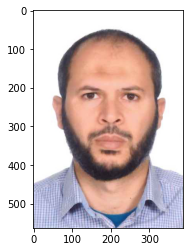

In [6]:
plt.imshow(person1)

In [7]:
person2 = cv2.imread('face_images/test/noureddin/noureddin18.jpg')
person2 = cv2.cvtColor(person2,cv2.COLOR_BGR2RGB)

In [8]:
person2.shape

(421, 312, 3)

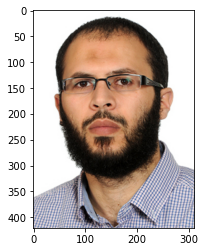

In [9]:
plt.imshow(person2)

## Preparing the Data for the model

Usually your training data contains lots and lots of images .. this is too much data to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [10]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image up to 20 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

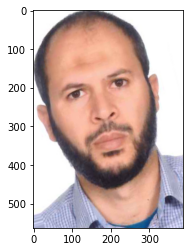

In [13]:
plt.imshow(image_gen.random_transform(person1))

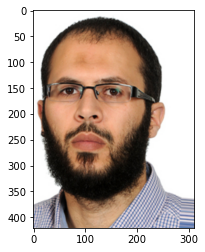

In [14]:
plt.imshow(image_gen.random_transform(person2))

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories (and this is what I have done for you .. this is the recommended way of doing it). This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [15]:
image_gen.flow_from_directory('face_images/train/')

Found 60 images belonging to 4 classes.


In [16]:
image_gen.flow_from_directory('face_images/test/')

Found 20 images belonging to 4 classes.


### Resizing Images

Let's have Keras resize all the images to 200 pixels by 180 pixels once they've been manipulated.

In [17]:
# width,height,channels
image_shape = (200,180,3)

# Creating the Model

In [43]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [46]:
model = Sequential()
# As we have seen on the slides .. we add Convolutional layers and follow them by Pooling
# Notice how we configure the number of filters, filter size etc 
# There are hyper parameters which we can experiment with!
# Check the padding parameter
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=132, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten the feature maps to feed into a dense layer as explained on the slides
model.add(Flatten())

# and here's our dense layer
model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its multi-class so we use softmax and categorical_crossentropy
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 198, 178, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 97, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 43, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 41, 132)       76164     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 20, 132)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 60720)            

### Training the Model

In [48]:
# you can experiment with this .. depends on data size etc
batch_size = 8

train_image_gen = image_gen.flow_from_directory('face_images/train/',
                                                #to automatically resize the images
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 60 images belonging to 4 classes.


In [49]:
train_image_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [50]:
test_image_gen = image_gen.flow_from_directory('face_images/test/',
                                               #to automatically resize the images
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 20 images belonging to 4 classes.


In [51]:
train_image_gen.class_indices

{'darda': 0, 'labenm': 1, 'noureddin': 2, 'sjcutt': 3}

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
results = model.fit_generator(train_image_gen,epochs=20,
                              #this is useful when you have a large number of images  len(Xtrain)//batch_size
                              steps_per_epoch=8,
                              validation_data=test_image_gen,
                             validation_steps=4)

Epoch 1/20
8/8 [==============================] - 2s 298ms/step - loss: 5.2017e-04 - accuracy: 1.0000 - val_loss: 0.4790 - val_accuracy: 0.9500
Epoch 2/20
8/8 [==============================] - 3s 324ms/step - loss: 0.1177 - accuracy: 0.9833 - val_loss: 0.5006 - val_accuracy: 0.9500
Epoch 3/20
8/8 [==============================] - 2s 311ms/step - loss: 0.0485 - accuracy: 0.9667 - val_loss: 0.4946 - val_accuracy: 0.9000
Epoch 4/20
8/8 [==============================] - 3s 379ms/step - loss: 0.0218 - accuracy: 0.9833 - val_loss: 0.2235 - val_accuracy: 0.9000
Epoch 5/20
8/8 [==============================] - 3s 339ms/step - loss: 0.0265 - accuracy: 0.9833 - val_loss: 0.0902 - val_accuracy: 0.9500
Epoch 6/20
8/8 [==============================] - 3s 332ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.1553 - val_accuracy: 0.9500
Epoch 7/20
8/8 [==============================] - 3s 402ms/step - loss: 0.1922 - accuracy: 0.9667 - val_loss: 0.1461 - val_accuracy: 0.9500
Epoch 8/20
8/8 [

Epoch 18/20
8/8 [==============================] - 3s 413ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.7324 - val_accuracy: 0.9500
Epoch 19/20
8/8 [==============================] - 3s 399ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.8257 - val_accuracy: 0.9500
Epoch 20/20
8/8 [==============================] - 7s 872ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8774 - val_accuracy: 0.9500


# Evaluating the Model

In [68]:
results.history

{'loss': [0.0005201661842875183,
  0.11771333962678909,
  0.04846052825450897,
  0.021817751228809357,
  0.02648494578897953,
  0.01425805501639843,
  0.19222258031368256,
  0.007090882398188114,
  0.044827383011579514,
  0.09431766718626022,
  0.08829609304666519,
  0.0018198712496086955,
  0.007504957262426615,
  0.036091335117816925,
  0.0024967268109321594,
  0.07394357025623322,
  0.007124368567019701,
  0.0032232541125267744,
  0.011685666628181934,
  0.0017048619920387864],
 'accuracy': [1.0,
  0.9833333492279053,
  0.9666666388511658,
  0.9833333492279053,
  0.9833333492279053,
  1.0,
  0.9666666388511658,
  1.0,
  0.9833333492279053,
  0.949999988079071,
  0.9833333492279053,
  1.0,
  1.0,
  0.9833333492279053,
  1.0,
  0.9833333492279053,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.4790131449699402,
  0.5006033182144165,
  0.4946104884147644,
  0.22348818182945251,
  0.09022430330514908,
  0.15525421500205994,
  0.14611417055130005,
  0.43108731508255005,
  0.065269246697425

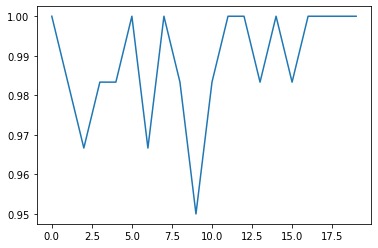

In [69]:
plt.plot(results.history['accuracy'])

# Predicting on new images

In [70]:
#train_image_gen.class_indices
label_map = train_image_gen.class_indices
label_map = dict(map(reversed, label_map.items()))


label_map

{0: 'darda', 1: 'labenm', 2: 'noureddin', 3: 'sjcutt'}

In [71]:
import numpy as np
from keras.preprocessing import image

test_file = 'face_images/test/noureddin/noureddin16.jpg'

test_img = image.load_img(test_file, target_size=(200, 180))

test_img = image.img_to_array(test_img)

test_img = np.expand_dims(test_img, axis=0)
test_img = test_img/255

In [72]:
model.predict_classes(test_img)

array([2])

In [73]:
prediction_prob = model.predict(test_img)

In [74]:
# Output prediction
print(f'Probabilities of classes for this image: {prediction_prob} ')

Probabilities of classes for this image: [[3.6201789e-04 4.8366086e-08 9.9963784e-01 8.9650399e-08]] 


In [75]:
y_prob = model.predict(test_img) 
label_map[y_prob.argmax(axis=-1)[0]]

'noureddin'

## Now let's save the model to use it with our live cam!

In [76]:
model.save('face_rec.h5')

# Well done!